In [1]:
from selenium import webdriver
import time
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.support.ui import WebDriverWait
import requests
from bs4 import BeautifulSoup
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
# importing libraries to plot the wordcloud
#from wordcloud import WordCloud, STOPWORDS
from wordcloud import WordCloud, STOPWORDS



In [2]:
local = "São Paulo"
email = 'caiocezar05@gmail.com'
senha = 'psx36547'


In [3]:
def login(email,senha):
    driver = webdriver.Chrome(r"C:\Users\caiozas\Documents\Python modelos\Web driver\chromedriver.exe")
    driver.get('https://www.linkedin.com/login')
    # waiting load
    time.sleep(2)

    # Search for login and password inputs, send credentions
    driver.find_element(By.ID,'username').send_keys(email)
    driver.find_element(By.ID,'password').send_keys(senha)
    try:
        driver.find_element(By.XPATH,'/html/body/div/div[1]/section/div[2]/div/article/footer/div/div/button[1]').click()
    except: pass

    driver.find_element(By.ID,'password').send_keys(Keys.RETURN)
    return driver


In [4]:

def job_Search_complete(driver,cargo,local,npages):
    
    driver.get(
    f"https://www.linkedin.com/jobs/search/?currentJobId=2662929045&geoId=106057199&keywords={cargo}&location={local}")
    # esperar carregar
    time.sleep(5)

    data = {'job':[],'description':[],'candidatos':[],'empresa':[],'local':[],'regime':[],'tipo empresa':[]}

    # loop para percorrer todas as páginas que forem listado
    # começando pela primeira e clicando na página 2
    pg_n = 1
    for i in range(2, npages+1):
                
        #depois da nona página, o próximo botão será sempre o 7
        if int(pg_n) > 7:
            i = 7
            
        try:
        # each page show us some jobs, sometimes show 25, others 13 or 21 ¯\_(ツ)_/¯
            jobs_lists = driver.find_element(By.CLASS_NAME,'jobs-search-results-list')  # here we create a list with jobs
            jobs = jobs_lists.find_elements(By.CLASS_NAME,'jobs-search-results__list-item')  # here we select each job to count
        # waiting load
            time.sleep(1)
        except:
            break
            print('isso é tudo')
        # the loop below is for the algorithm to click exactly on the number of jobs that is showing in list
        # in order to avoid errors that will stop the automation
        for job in jobs:
            # job click
            try: 
                job.click()
                time.sleep(.5)
                job.click()
            # waiting load                     
                time.sleep(.5)
            # select job descriptio
            except: pass
            
            try:
                page = driver.page_source
                soup = BeautifulSoup(page,features="html.parser")
                job_desc = soup.find('div',{'class': "jobs-description__content jobs-description-content"}).find_all('span')
                pg_n = soup.find('ul',{'class': "artdeco-pagination__pages artdeco-pagination__pages--number"}).find_all('span')[6].text
                pg_selected = soup.find('ul',{'class': "artdeco-pagination__pages artdeco-pagination__pages--number"}).find('button',{"aria-current":"true"}).span.text

                
                ul = []
                head = []

            except:
                driver.back()
                time.sleep(1)
                print("deu ruim, bixo, pg: ",pg_selected)
                
                page = driver.page_source
                soup = BeautifulSoup(page,features="html.parser")
                job_desc = soup.find('div',{'class': "jobs-description__content jobs-description-content"}).find_all('span')
                pg_n = soup.find('ul',{'class': "artdeco-pagination__pages artdeco-pagination__pages--number"}).find_all('span')[6].text
                pg_selected = soup.find('ul',{'class': "artdeco-pagination__pages artdeco-pagination__pages--number"}).find('button',{"aria-current":"true"}).span.text
                pass
            #coletar os dados da lista de vagas
            
            for span in job_desc:

                try: data['description'].append(span.text)
                except: data['description'].append('')
                        
                try: data['job'].append(job.text.replace('\n','|'))
                except: data['job'].append('')
                    
                try:
                    data['candidatos'].append(soup.find('span',{'class': "jobs-unified-top-card__applicant-count"}).text.replace('  ','').replace('\n',''))
                except: data['candidatos'].append('')
                    
                try:
                    data['empresa'].append(soup.find('span',{'class': "jobs-unified-top-card__company-name"}).text.replace('  ','').replace('\n',''))
                except: data['empresa'].append('')
                    
                try:
                    data['local'].append(soup.find('span',{'class': "jobs-unified-top-card__bullet"}).text.replace('  ','').replace('\n',''))
                except: data['local'].append('')
                    
                try:
                    data['regime'].append(soup.find('span',{'class': "jobs-unified-top-card__workplace-type"}).text.replace('  ','').replace('\n',''))
                except: data['regime'].append('')

                try:
                    data['tipo empresa'].append(soup.find('div',{'class': "mt5 mb2"}).find_all('span')[1].text.replace('\n',''))
                except: data['tipo empresa'].append('')
                    
                    
        # Clicar no botão para carregar a próxima página
        # tem 2 loops porque as vezes o botão "muda de lugar" no caminho do HTMLe
            
        if int(pg_selected) >= int(pg_n):
            i = 9
        try:
            driver.execute_script("arguments[0].scrollIntoView();", WebDriverWait(driver, 20).until(EC.element_to_be_clickable((By.XPATH, f'/html/body/div[5]/div[3]/div[4]/div/div/main/div/section[1]/div/div[6]/ul/li[{i}]/button'))))
            time.sleep(1)
            driver.find_element(By.XPATH, f'/html/body/div[5]/div[3]/div[4]/div/div/main/div/section[1]/div/div[6]/ul/li[{i}]/button').click()
            time.sleep(2)                   
        
        except:
            try:
                driver.execute_script("arguments[0].scrollIntoView();", WebDriverWait(driver, 20).until(EC.element_to_be_clickable((By.XPATH, f'/html/body/div[4]/div[3]/div[4]/div/div/main/div/section[1]/div/div[6]/ul/li[{i}]/button'))))
                time.sleep(1)
                driver.find_element(By.XPATH, f'/html/body/div[4]/div[3]/div[4]/div/div/main/div/section[1]/div/div[6]/ul/li[{i}]/button').click()
                time.sleep(2)                    
            except:
                try:
                    driver.execute_script("arguments[0].scrollIntoView();", WebDriverWait(driver, 20).until(EC.element_to_be_clickable((By.XPATH, f'/html/body/div[5]/div[3]/div[4]/div/div/main/div/section[1]/div/div[7]/ul/li[{i}]/button'))))
                    time.sleep(1)
                    driver.find_element(By.XPATH, f'/html/body/div[5]/div[3]/div[4]/div/div/main/div/section[1]/div/div[7]/ul/li[{i}]/button').click()
                    time.sleep(2)                   
                except:
                    try:
                        driver.execute_script("arguments[0].scrollIntoView();", WebDriverWait(driver, 20).until(EC.element_to_be_clickable((By.XPATH, f'/html/body/div[4]/div[3]/div[4]/div/div/main/div/section[1]/div/div[7]/ul/li[{i}]/button'))))
                        time.sleep(1)
                        driver.find_element(By.XPATH, f'/html/body/div[4]/div[3]/div[4]/div/div/main/div/section[1]/div/div[7]/ul/li[{i}]/button').click()
                        time.sleep(2)                   
                    except:
                        try:
                            driver.execute_script("arguments[0].scrollIntoView();", WebDriverWait(driver, 20).until(EC.element_to_be_clickable((By.XPATH, f'/html/body/div[5]/div[3]/div[4]/div/div/main/div/section[1]/div/div[5]/ul/li[{i}]/button'))))
                            time.sleep(1)                                                                                                                   
                            driver.find_element(By.XPATH, f'/html/body/div[5]/div[3]/div[4]/div/div/main/div/section[1]/div/div[5]/ul/li[{i}]/button').click()
                            time.sleep(2)                   
                        except:
                            print("Last page reached ",pg_selected)
                            break

 

    # Passando o dicionário para um dataframe
    df = pd.DataFrame(data)
    
    return df

In [5]:
driver = login(email,senha)

C:\Users\caiozas\AppData\Local\Temp\ipykernel_17848\3243509756.py:2: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome(r"C:\Users\caiozas\Documents\Python modelos\Web driver\chromedriver.exe")


In [6]:
job = "analista FP%26A"

vaga1 = job_Search_complete(driver,job,local,npages=40)
vaga1['jobp'] = job
vaga1 = vaga1.drop_duplicates()

deu ruim, bixo, pg:  5
deu ruim, bixo, pg:  13
deu ruim, bixo, pg:  15
deu ruim, bixo, pg:  18
deu ruim, bixo, pg:  28
Last page reached  32


In [7]:
vaga1['candidatos'] = pd.to_numeric(vaga1['candidatos'].str.replace('candidaturas','').str.replace('candidatura','').str.replace(' ','').fillna(0))
vaga1['tamanho'] = vaga1['tipo empresa'].str.split('·',expand=True)[0].str.replace(' funcionários','')
vaga1['tamanho'] = vaga1['tamanho'].str.split('-',expand=True)[1]
vaga1['tamanho'] = vaga1['tamanho'].str.replace(' ','')
vaga1['atuação'] = vaga1['tipo empresa'].str.split('·',expand=True)[1]


In [8]:
vaga1.to_excel('LinkedIn Planejamento Financeiro 10.02.xlsx')

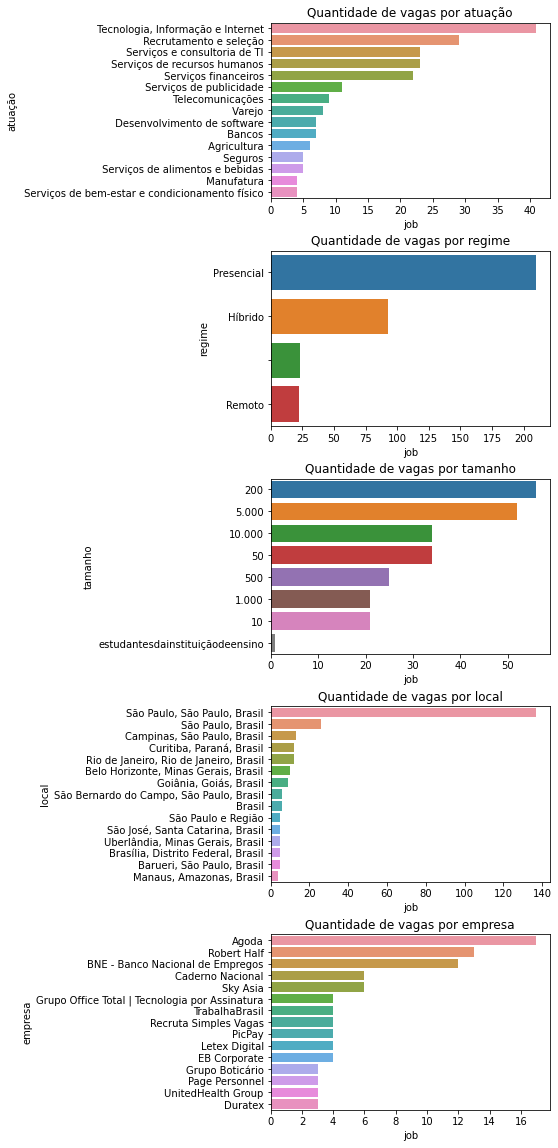

In [9]:
parametros_plot = ['atuação','regime','tamanho','local','empresa']


fig, axes = plt.subplots(len(parametros_plot),figsize=(5,20))
plt.subplots_adjust(wspace=5,hspace=.3)
n=0
for compare in parametros_plot:
    df_bar = data=vaga1.groupby([compare],as_index=False)['job'].count().sort_values('job',ascending=False)
    sns.barplot(ax=axes[n],data=df_bar.head(15),
            y=compare,
            x='job').set_title(f'Quantidade de vagas por {compare}')
    n+=1



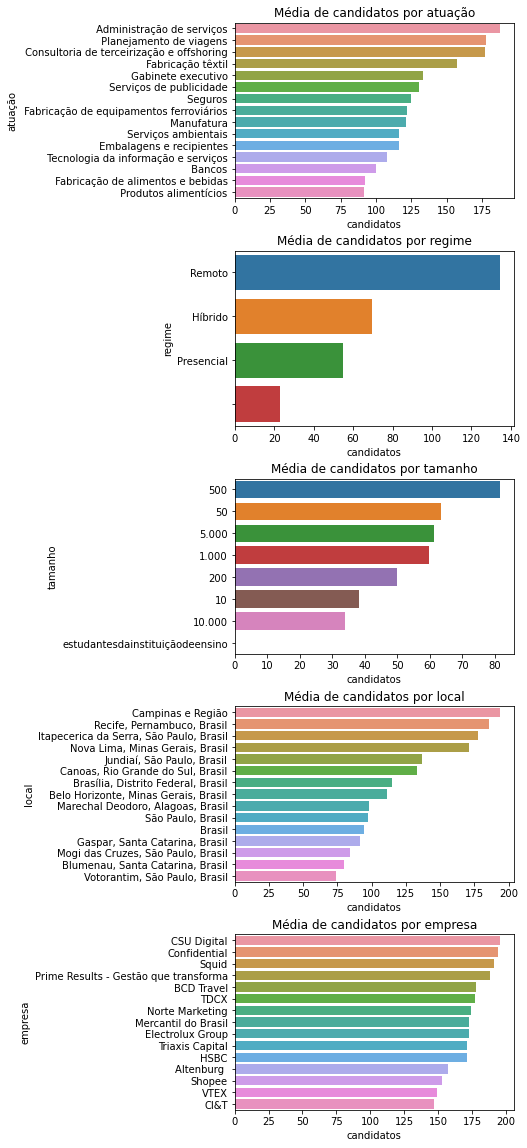

In [10]:
parametros_plot = ['atuação','regime','tamanho','local','empresa']

fig, axes = plt.subplots(len(parametros_plot),figsize=(5,20))
plt.subplots_adjust(wspace=5,hspace=.3)
n=0
for compare in parametros_plot:
    df_bar = data=vaga1.groupby([compare],as_index=False)['candidatos'].mean().sort_values('candidatos',ascending=False)
    sns.barplot(ax=axes[n],data=df_bar.head(15),
            y=compare,
            x='candidatos').set_title(f'Média de candidatos por {compare}')
    n+=1

